## 020 Compare performance of EVRPE and cue-induced craving models (single subject)

Date: 05.Aug.2022

### Purpose

Compare the performance of joint cue-induced craving (CEC) models with biased, heuristic, and RW decision-making to expectation-based (EVRPE) models.

### Outline of Plan

1. Implement biased, heuristic, and RW version of CEC models, copy from NB#005.
2. Copy "active", EVRPE, RW, 0-, 1-, 2-step, binomial prediction models from NB#019 (default from here).
3. Visualize posterior predictive simulation for all models.
4. Compare model performance for craving and decision-making.

### What we did in this notebook

1. Implement biased, heuristic, RW joint models with CEC.
2. Rerun active 0-, 1-, 2-step RW-EVRPE joint models from latest_models_binomial.py.
3. Utils plotting function to calculate and visualize correlations between predicted and true craving for all traces.
4. Model comparison between all models for decision-making and craving.

### Overall conclusions
1. Decision-making models are excellent as expected. RW variants outperform heuristic and biased models by a large margin.
2. Craving is not as clear cut. WAIC for craving models is actually better for CEC models, but correlations between predicted and true cravings are significantly higher for the EVRPE models. Of course, this might be due to overfitting, but intuitively it doesn't feel that way. Even the 0 step model EVRPE model, which doesn't have a ton of parameters, has higher correlations.
3. The next major step would be to test a craving model which explicitly combined EVRPE and CEC prediction estimates. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
from scipy import stats
import time
import arviz as az

from abc import ABC, abstractmethod

from sys import path
import os

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

from latest_models_binomial import RetroPrototype

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [3]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.5) & 
    (df_summary['Other Accuracy']>0.5)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
print(pid_list.shape)
longform

(36,)


,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Define null model classes

In [5]:
class BiasedCEC:
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'Biased_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'Biased'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def right_action_probs(self, actions, rewards, *args):
        
        sample_bias, weight_zero, weight_one = args

        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        probs = at.repeat(sample_bias, t_actions.shape[0])
        pred_cravings = weight_zero + weight_one*t_rewards

        return probs[1:],  pm.invlogit(pred_cravings)
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    def _define_priors(self):
        untr_bias = pm.Normal('untr_bias', mu=0, sigma=1)
        bias = pm.Deterministic('bias', pm.math.invlogit(untr_bias))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return bias, weight_zero, weight_one
        

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Binomial('craving_like', n=50, p=craving_pred[self.craving_inds-1], observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [6]:
class HeuCEC:
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'Heuristic_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'Heuristic'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def add_eps(self, st, a, eps_t, eps):
        return aesara.ifelse.ifelse(
                at.eq(st, 1),
                aesara.ifelse.ifelse(
                    at.eq(a, 1),
                    eps,
                    1-eps
                ),
                aesara.ifelse.ifelse(
                    at.eq(a, 1),
                    1-eps,
                    eps
                )
            )
    
    def right_action_probs(self, actions, rewards, strat, *args):
        
        sample_eps, weight_zero, weight_one = args

        t_strat = at.as_tensor_variable(strat, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')

        # Compute the Qs values
        t_eps = at.as_tensor_variable(np.asarray(1, 'float64'))
        t_eps, updates = aesara.scan(
            fn=self.add_eps,
            sequences=[t_strat, t_actions],
            outputs_info=t_eps,
            non_sequences=[sample_eps])
        
        pred_cravings = weight_zero + weight_one*t_rewards

        return t_eps[1:],  pm.invlogit(pred_cravings)
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    def _define_priors(self):
        untr_eps = pm.Normal('untr_eps', mu=0, sigma=1)
        eps = pm.Deterministic('eps', pm.math.invlogit(untr_eps))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return eps, weight_zero, weight_one
        

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        strat = np.zeros(len(act))
        for i, a in enumerate(act):
            if i < 2:
                continue
            should_switch = np.all(np.array([rew[i-2]==rew[i-1], rew[i-1]==0]), axis=0)
            do_switch = act[i-1]!=act[i]
            strat[i] = should_switch==do_switch
        strat = strat.astype(int)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, strat, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Binomial('craving_like', n=50, p=craving_pred[self.craving_inds-1], observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [7]:
class RWCEC():
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'RW_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'RW'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))
        return Qs

    def right_action_probs(self, actions, rewards, beta, *args):
        alpha, weight_zero, weight_one = args
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        loopvals =  at.zeros((7,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        # t_pred_craving = pm.invlogit(loopvals[:, 2])
        t_pred_craving = weight_zero + weight_one*t_rewards

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  pm.math.invlogit(t_pred_craving)
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Binomial('craving_like', n=50, p=craving_pred[self.craving_inds-1], observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

## Retrospective prototype class imports

In [9]:
## Standard binomial classes
from latest_models_binomial import A_RW_0step as A0B
from latest_models_binomial import A_RW_1stepSep as A1B
from latest_models_binomial import A_RW_2stepSep as A2B

## Batchfit class
from latest_models_normal import BatchFit

## Fit models

In [10]:
biasedcec = BiasedCEC(longform, df_summary, project_dir, None)
heucec = HeuCEC(longform, df_summary, project_dir, None)
rwcec = RWCEC(longform, df_summary, project_dir, None)
a0b = A0B(longform, df_summary, project_dir, None)
a1b = A1B(longform, df_summary, project_dir, None)
a2b = A2B(longform, df_summary, project_dir, None)

In [12]:
for pid_num in [12]:
    biasedcec.fit(pid_num, 'other')
    heucec.fit(pid_num, 'other')
    rwcec.fit(pid_num, 'other')
    a0b.fit(pid_num, 'other')
    a1b.fit(pid_num, 'other')
    a2b.fit(pid_num, 'other')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [untr_bias]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [untr_eps]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [weight_five]
>Metropolis: [weight_six]
>Metropolis: [mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


In [69]:
save_path_nb14 = f'{root_dir}/bayesian_models/slotscraving/exploration/20_trace_output/'
for pid_num in [12]:
    biasedcec.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/biased_{pid_num}_other.nc')
    heucec.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/heu_{pid_num}_other.nc')
    rwcec.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/rwcec_{pid_num}_other.nc')
    a0b.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/a0b_{pid_num}_other.nc')
    a1b.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/a1b_{pid_num}_other.nc')
    a2b.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/a2b_{pid_num}_other.nc')

In [69]:
# Load instead of fitting
save_path_nb14 = f'{root_dir}/bayesian_models/slotscraving/exploration/14_trace_output/'
for pid_num in [8]:
    # write loading function
    pass

## Output posterior

In [15]:
pid_num = 12

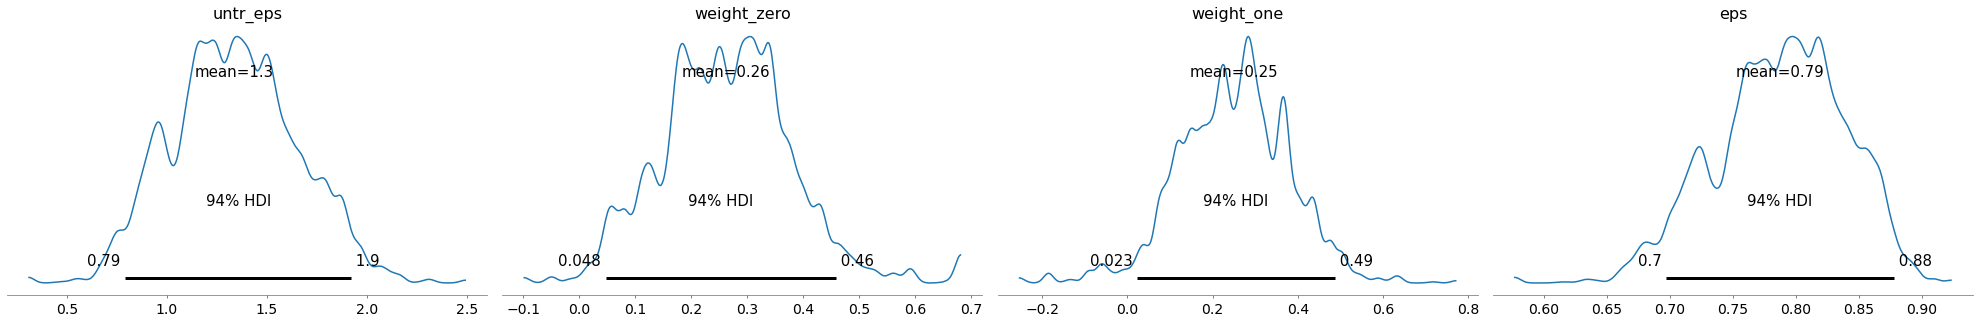

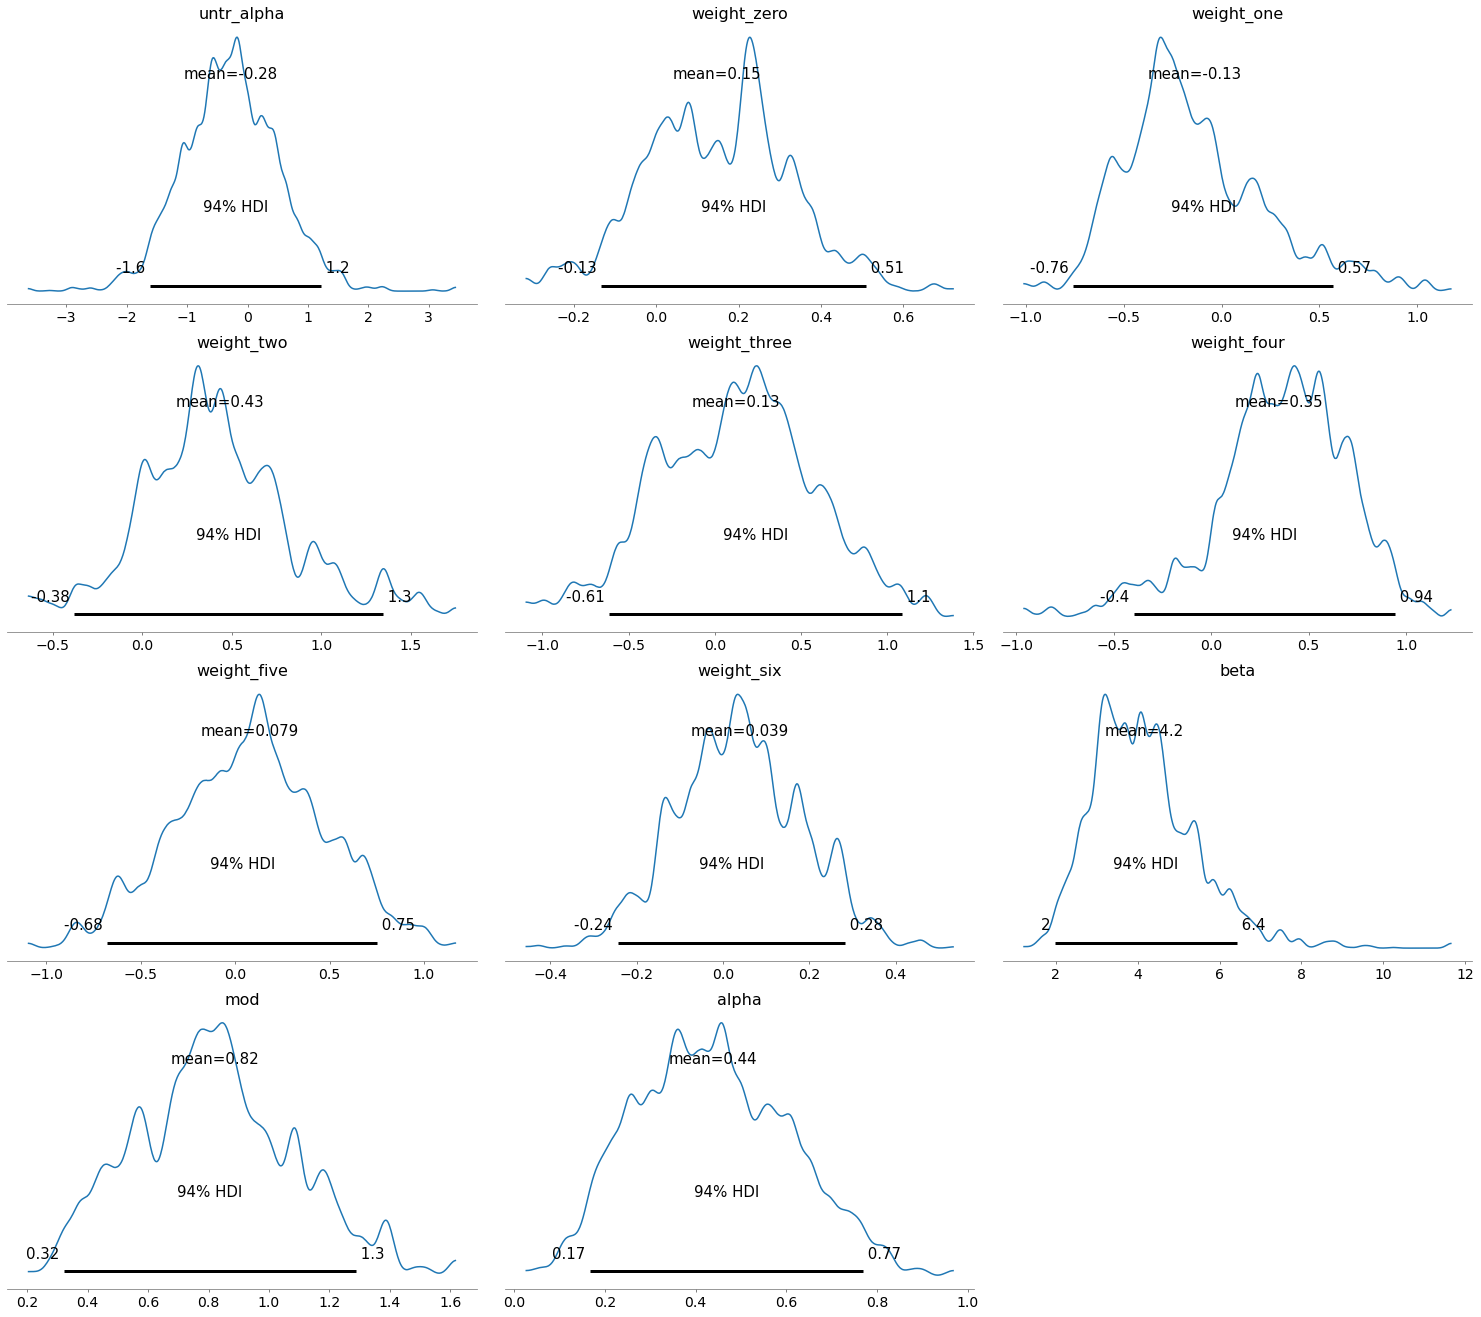

In [16]:
# az.plot_posterior(activev1_2step_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
# az.plot_posterior(activev2_2step_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
az.plot_posterior(heucec.traces['other'][pid_list[pid_num]])
plt.tight_layout()
az.plot_posterior(a2b.traces['other'][pid_list[pid_num]])
plt.tight_layout()


## Plotting utils

In [17]:
def plot_ppc_craving(models, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
    model_names = [m.name for m in models]
    samp_model = models[0]
    sns.lineplot(
        x=np.arange(samp_model.cravings[b, pid_num].shape[0]),
        y=samp_model.cravings[b, pid_num],
        label='True craving',
        color='black'
    )
    for i, model in enumerate(models):
        sns.lineplot(
            x=np.arange(len(model.cravings[b, pid_num])),
            y=model.traces[block][model.pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
            label=f'{model_names[i]}'
        )
    plt.tight_layout()
    plt.close()
    return fig


In [18]:
def plot_ppc_norm_craving(models, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
    model_names = [m.name for m in models]
    samp_model = models[0]
    sns.lineplot(
        x=np.arange(samp_model.norm_cravings[b, pid_num].shape[0]),
        y=samp_model.norm_cravings[b, pid_num],
        label='True craving',
        color='black'
    )
    for i, model in enumerate(models):
        sns.lineplot(
            x=np.arange(len(model.norm_cravings[b, pid_num])),
            y=model.traces[block][model.pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
            label=f'{model_names[i]}'
        )
    plt.tight_layout()
    plt.close()
    return fig


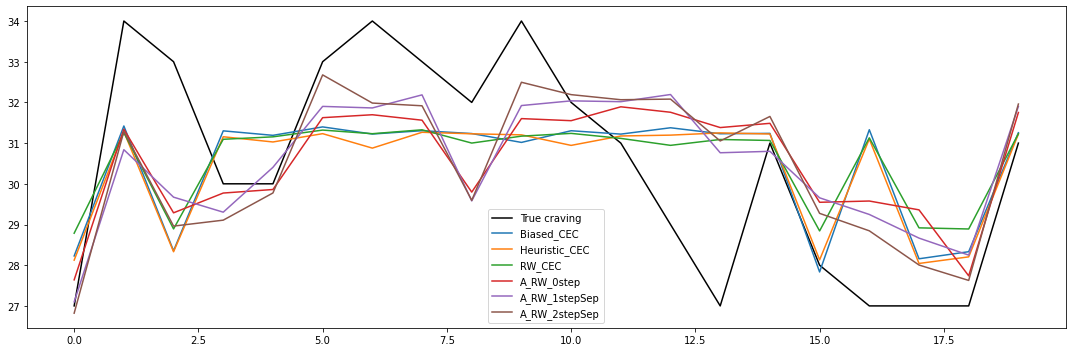

In [20]:
plot_ppc_craving([
    biasedcec, heucec, rwcec,
    a0b, a1b, a2b,
], pid_num, 'other')

In [40]:
for model in [biasedcec, heucec, rwcec, a0b, a1b, a2b]:
    print(model.name, stats.pearsonr(
        model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like[2].mean(axis=0).values,
        model.cravings[1, pid_num]
    ))

Biased_CEC (0.4740694722815073, 0.03471184306608828)
Heuristic_CEC (0.4335593768898706, 0.05616416360358336)
RW_CEC (0.495310287217164, 0.026376628021299777)
A_RW_0step (0.604259404597737, 0.004775251086247441)
A_RW_1stepSep (0.6870598583392485, 0.000818119209439025)
A_RW_2stepSep (0.6458311990675673, 0.0020985226873649963)


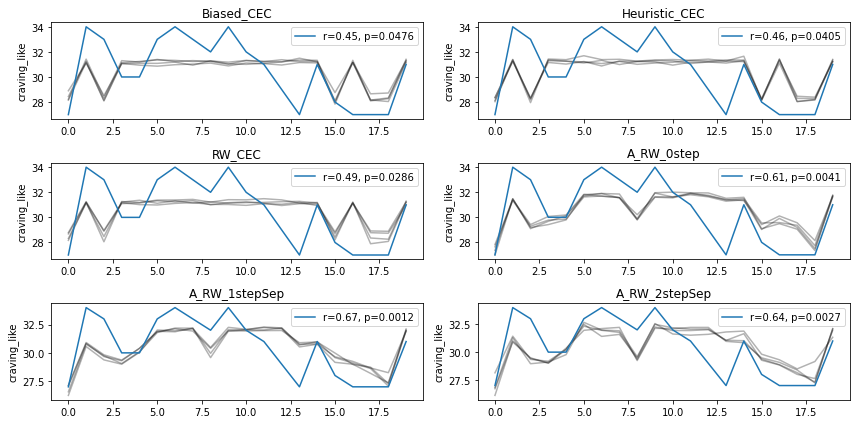

In [56]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,6), facecolor='w', edgecolor='k')

for i, model in enumerate([biasedcec, heucec, rwcec, a0b, a1b, a2b]):
    rs = []
    ps = []
    for trace in model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like:
        r, p = stats.pearsonr(trace.mean(axis=0), model.cravings[1, pid_num])
        rs.append(r)
        ps.append(p)
        sns.lineplot(
            x=np.arange(len(model.cravings[1, pid_num])), 
            y=trace.mean(axis=0), ax=ax[i//2, i%2], 
            color='black', alpha=0.3)
    sns.lineplot(
        x=np.arange(len(model.cravings[1, pid_num])), 
        y=model.cravings[1, pid_num], 
        label=f'r={np.round(np.mean(rs), 2)}, p={np.round(np.mean(ps), 4)}', 
        ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(model.name)

plt.tight_layout()

## Model comparison of EV and EVRPE

In [66]:
model_comp = az.compare({
        'Biased': biasedcec.traces['other'][pid_list[pid_num]],
        'Heuristic': heucec.traces['other'][pid_list[pid_num]],
        'RWCEC': rwcec.traces['other'][pid_list[pid_num]],
        'Active0Binom': a0b.traces['other'][pid_list[pid_num]],
        'Active1Binom': a1b.traces['other'][pid_list[pid_num]],
        'Active2Binom': a2b.traces['other'][pid_list[pid_num]],
    },
    ic='waic',
    var_name='craving_like'
)
model_comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Biased,0,-48.741168,0.840946,0.000000,7.869187e-01,1.340676,0.000000,False,log
Heuristic,1,-48.751458,0.855978,0.010291,1.651743e-15,1.376836,0.071116,False,log
Active0Binom,2,-48.849331,1.276844,0.108163,2.130813e-01,1.124262,0.615243,False,log
RWCEC,3,-48.889344,0.939864,0.148177,0.000000e+00,1.290930,0.102561,False,log
Active1Binom,4,-49.102631,1.628627,0.361463,0.000000e+00,1.027863,0.846501,False,log
Active2Binom,5,-49.947081,2.119074,1.205914,0.000000e+00,1.185781,0.884587,False,log


<AxesSubplot:xlabel='Log'>

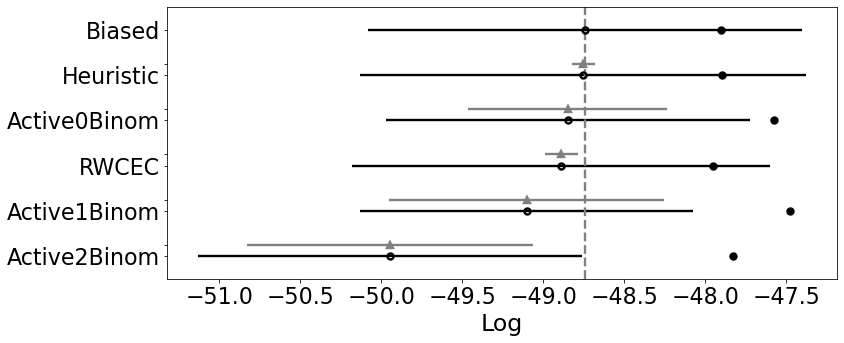

In [68]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))

In [61]:
model_comp = az.compare({
        'Biased': biasedcec.traces['other'][pid_list[pid_num]],
        'Heuristic': heucec.traces['other'][pid_list[pid_num]],
        'RWCEC': rwcec.traces['other'][pid_list[pid_num]],
        'Active0Binom': a0b.traces['other'][pid_list[pid_num]],
        'Active1Binom': a1b.traces['other'][pid_list[pid_num]],
        'Active2Binom': a2b.traces['other'][pid_list[pid_num]],
    },
    ic='waic',
    var_name='like'
)
model_comp

/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/pymc_en

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Active1Binom,0,-20.468517,1.865668,0.000000,9.148043e-01,4.912313,0.000000,True,log
Active0Binom,1,-20.544144,1.851995,0.075627,1.147563e-15,4.897554,0.162956,True,log
Active2Binom,2,-20.607725,2.075837,0.139208,6.893353e-03,5.061083,0.269524,True,log
RWCEC,3,-20.633683,1.465147,0.165166,0.000000e+00,4.710430,0.996530,True,log
Heuristic,4,-29.382794,0.880542,8.914277,7.830232e-02,4.091369,4.397937,False,log
Biased,5,-40.817542,0.943755,20.349024,0.000000e+00,1.327723,4.861217,False,log


<AxesSubplot:xlabel='Log'>

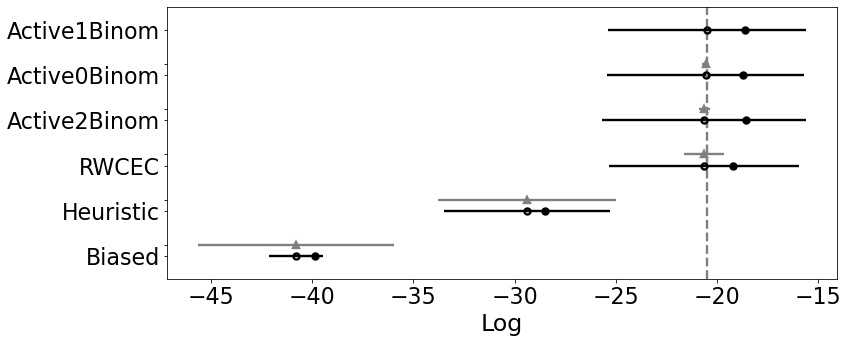

In [62]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))